In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-ai-job-market-and-salary-trends-2025/ai_job_dataset.csv


In [2]:
# Load the dataset
df = pd.read_csv("/kaggle/input/global-ai-job-market-and-salary-trends-2025/ai_job_dataset.csv")

# Clean and preprocess
df['salary_usd'] = pd.to_numeric(df['salary_usd'], errors='coerce')
df.dropna(subset=['salary_usd'], inplace=True)
df.drop_duplicates(inplace=True)

# Define features and target
features = [
    'experience_level', 'employment_type', 'company_location', 'company_size',
    'employee_residence', 'remote_ratio', 'education_required', 'years_experience'
]
target = 'salary_usd'
X = df[features]
y = df[target]

# One-hot encode categorical features
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

categorical = [
    'experience_level', 'employment_type', 'company_location',
    'company_size', 'employee_residence', 'education_required'
]
numerical = ['remote_ratio', 'years_experience']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('num', 'passthrough', numerical)
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train 3 models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

results = []
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    results.append((name, rmse, r2))

# Show model performance
results_df = pd.DataFrame(results, columns=["Model", "RMSE", "R² Score"])
print(results_df)


               Model          RMSE  R² Score
0  Linear Regression  23185.022621  0.852614
1      Random Forest  21917.261915  0.868291
2            XGBoost  21544.720800  0.872731


**Actual versus Prediction**

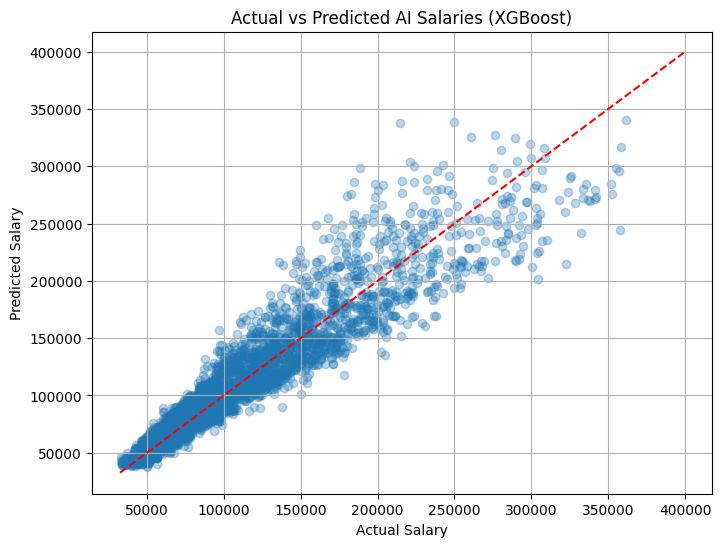

In [3]:
import matplotlib.pyplot as plt

# Predict using best model (XGBoost)
best_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42, verbosity=0))
])
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, preds, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted AI Salaries (XGBoost)')
plt.grid(True)
plt.show()


**Salary Distributio**

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


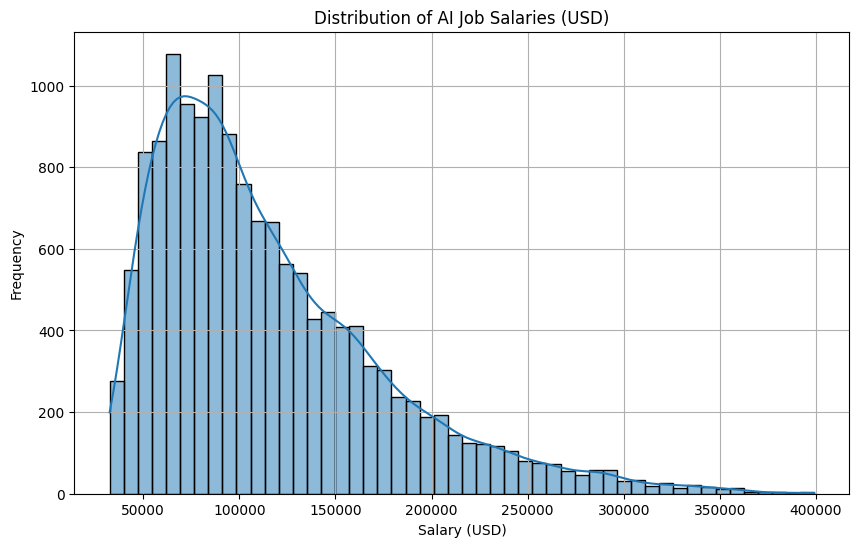

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.histplot(df['salary_usd'], bins=50, kde=True)
plt.title("Distribution of AI Job Salaries (USD)")
plt.xlabel("Salary (USD)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


**Average Salary by Country (Top 15)**

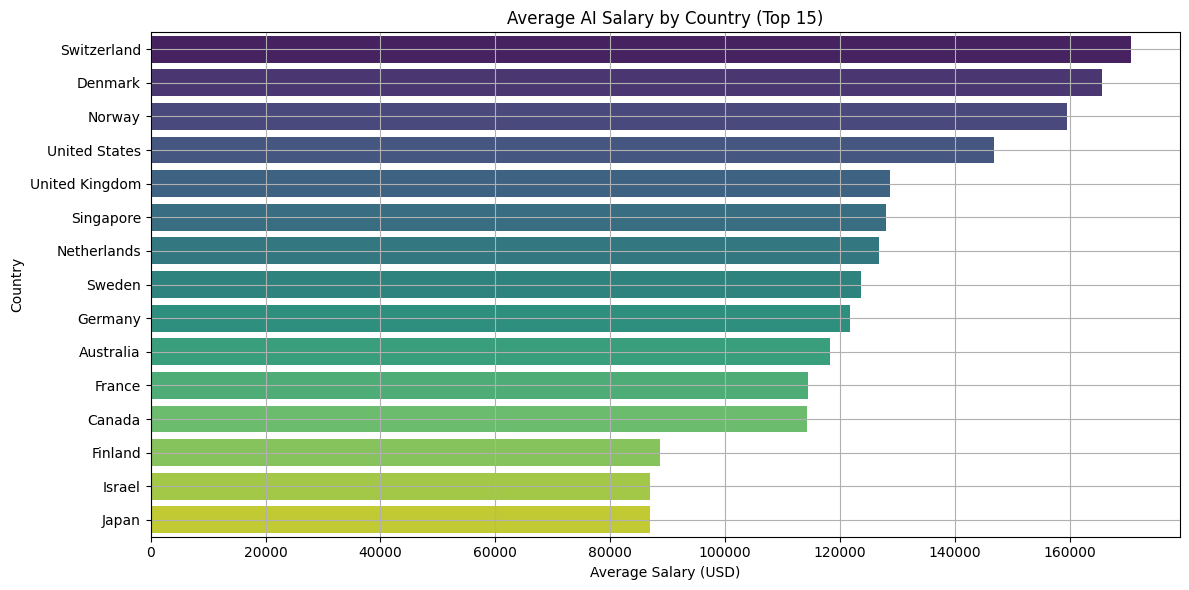

In [5]:
# Average salary per country (Top 15)
country_avg = df.groupby("company_location")["salary_usd"].mean().sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x=country_avg.values, y=country_avg.index, palette="viridis")
plt.title("Average AI Salary by Country (Top 15)")
plt.xlabel("Average Salary (USD)")
plt.ylabel("Country")
plt.grid(True)
plt.tight_layout()
plt.show()

**Salary Comparison by Degree & Country (Heatmap)**

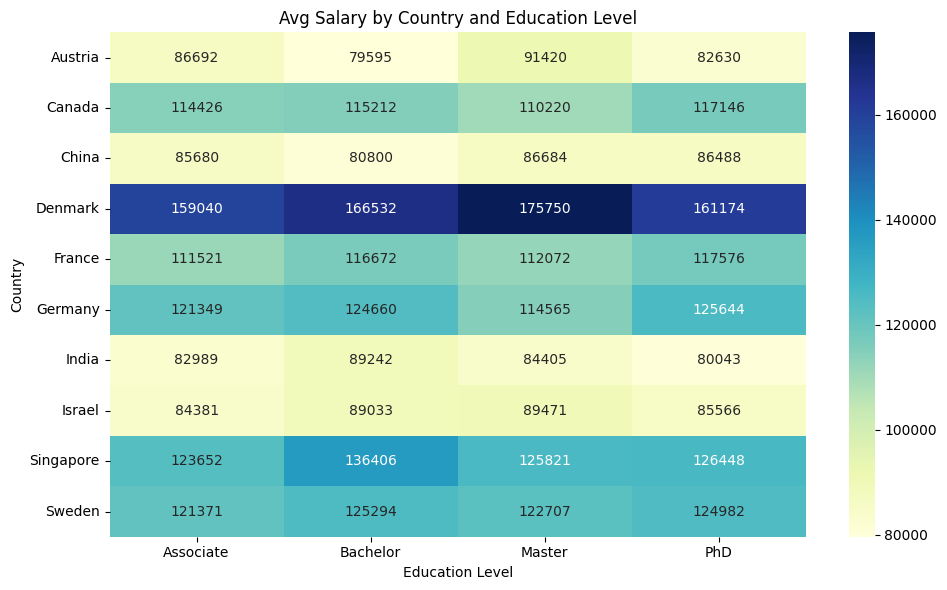

In [6]:
# Pivot table: average salary by country and education level
pivot = df.pivot_table(
    values="salary_usd",
    index="company_location",
    columns="education_required",
    aggfunc="mean"
)

# Show top countries only (optional)
top = df["company_location"].value_counts().head(10).index
pivot = pivot.loc[pivot.index.isin(top)]

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Avg Salary by Country and Education Level")
plt.xlabel("Education Level")
plt.ylabel("Country")
plt.tight_layout()
plt.show()
